In [1]:
# --- Standard libraries
import pickle as pkl
import numpy as np
from icecream import ic
# --- PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# --- Modules from local files
from GNN_mol import GNN
from Dataset import XASDataset
from train import train_model
from test import test_model
from utils import plot_learning_curve

c:\Users\a3782\AppData\Local\anaconda3\envs\pyg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Import dataset

In [2]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset(path)

Processing...


Total number of molecules 319
Number of atoms in each molecule  [25, 25, 25, 24, 24, 24, 26, 25, 24, 24, 26, 24, 27, 24, 24, 24, 27, 24, 24, 25, 24, 24, 25, 25, 24, 26, 24, 26, 24, 25, 26, 24, 26, 25, 24, 26, 24, 26, 25, 26, 25, 24, 27, 25, 25, 25, 24, 28, 25, 26, 24, 25, 24, 24, 24, 25, 25, 26, 24, 24, 24, 25, 28, 26, 26, 24, 27, 24, 26, 26, 24, 26, 25, 26, 24, 24, 26, 25, 25, 25, 24, 24, 24, 24, 24, 24, 27, 24, 26, 26, 24, 24, 24, 24, 26, 25, 25, 24, 24, 27, 25, 24, 25, 24, 24, 25, 24, 26, 24, 25, 24, 25, 24, 26, 25, 26, 26, 24, 24, 25, 24, 26, 27, 24, 24, 25, 25, 26, 26, 25, 25, 24, 25, 25, 25, 27, 24, 24, 26, 24, 24, 24, 24, 24, 25, 24, 25, 24, 25, 25, 25, 24, 24, 24, 26, 25, 24, 26, 27, 24, 26, 24, 24, 24, 24, 24, 26, 27, 24, 24, 28, 24, 27, 25, 27, 25, 24, 26, 27, 24, 26, 26, 24, 27, 24, 24, 25, 24, 26, 26, 26, 24, 26, 24, 24, 27, 25, 24, 26, 24, 24, 24, 26, 27, 28, 24, 27, 24, 25, 25, 24, 25, 25, 24, 26, 24, 24, 26, 24, 24, 26, 24, 26, 24, 24, 25, 24, 24, 24, 25, 24, 27, 25, 24,

Done!


In [3]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(319)
------------
Number of graphs: 319
Number of features: 17
Number of classes: 0

Data(x=[28, 17], edge_index=[2, 72], edge_attr=[72, 6], spectrum=[200], idx=[1], smiles='c12[c:2]3[cH:1][cH:23][c:22]4[c:20]1[c:16]1[c:18]([cH:19][c:21]4[OH:24])[CH:17]4[CH:15]([C:14]5([OH:27])[CH:12]1[C:8]16[c:4]2[c:6]([cH:5][cH:3]3)[CH:7]=[CH:9][C:10]1([CH:11]=[CH:13]5)[O:26]6)[O:25]4')
------------
Number of nodes: 28
Number of edges: 72
Average node degree: 2.57
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [4]:
torch.save(dataset, './processed/mol_dataset.pt')

#### View data

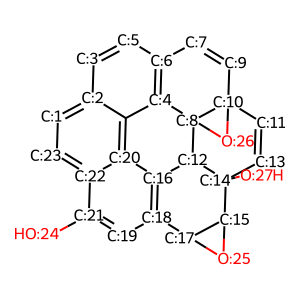

In [5]:
mol = Chem.MolFromSmiles(data.smiles)
mol

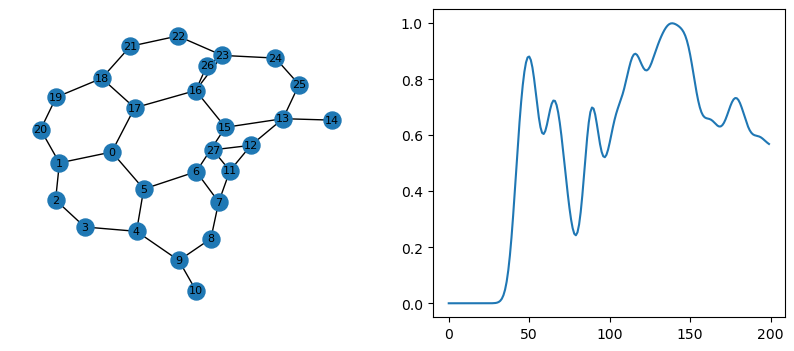

In [6]:
# --- Create subplot for plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show molecule spectrum
ax2.plot(data.spectrum)
plt.show()

#### Split up dataset

In [7]:
# --- Split data into test, validation and test
train_dataset = dataset[0:244]
val_dataset = dataset[245:270]
test_dataset = dataset[280:]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=244, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=25, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=39, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datassets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

Length of training data loader: 244, with a total of 1 datassets
Length of validation data loader: 25, with a total of 1 datasets
Length of testing data loader: 39, with a total of 1 datasets


In [16]:
torch.save(test_dataset, './processed/mol_test_dataset.pt')

#### Set neural network properties

In [9]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 256, 128]
out_channels = [256, 128, 64]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.6
graph_pooling = "mean"

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(17, 256)
      (1): GCNConv(256, 128)
      (2): GCNConv(128, 64)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=64, out_features=200, bias=True)
)


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [12]:
num_epochs = 500
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    loss = train_model(epoch, train_loader, model, device, optimizer)

    val_error = test_model(val_loader, model, device)

    scheduler.step(val_error)

    train_losses.append(loss)

    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if best_val_error is None or val_error <= best_val_error:

        best_val_error = val_error

    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}")

Epoch: 000, LR: 0.010000, TrainLoss: 0.2567384, ValLoss:0.280634, Best_ValLoss:0.280634
Epoch: 025, LR: 0.010000, TrainLoss: 0.0287355, ValLoss:0.016927, Best_ValLoss:0.016927
Epoch: 050, LR: 0.010000, TrainLoss: 0.0147349, ValLoss:0.009642, Best_ValLoss:0.009642
Epoch: 075, LR: 0.010000, TrainLoss: 0.0105832, ValLoss:0.008901, Best_ValLoss:0.008712
Epoch: 100, LR: 0.010000, TrainLoss: 0.0098012, ValLoss:0.008349, Best_ValLoss:0.008334
Epoch: 125, LR: 0.010000, TrainLoss: 0.0091121, ValLoss:0.008264, Best_ValLoss:0.008253
Epoch: 150, LR: 0.010000, TrainLoss: 0.0089759, ValLoss:0.007936, Best_ValLoss:0.007936
Epoch: 175, LR: 0.010000, TrainLoss: 0.0087710, ValLoss:0.007999, Best_ValLoss:0.007867
Epoch: 200, LR: 0.010000, TrainLoss: 0.0080407, ValLoss:0.007936, Best_ValLoss:0.007867
Epoch: 225, LR: 0.010000, TrainLoss: 0.0082452, ValLoss:0.007925, Best_ValLoss:0.007827
Epoch: 250, LR: 0.010000, TrainLoss: 0.0078180, ValLoss:0.008149, Best_ValLoss:0.007827
Epoch: 275, LR: 0.010000, TrainL

In [13]:
val_losses[-1]

0.007992585024248553

In [14]:
model_name = 'model_gnn_test.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

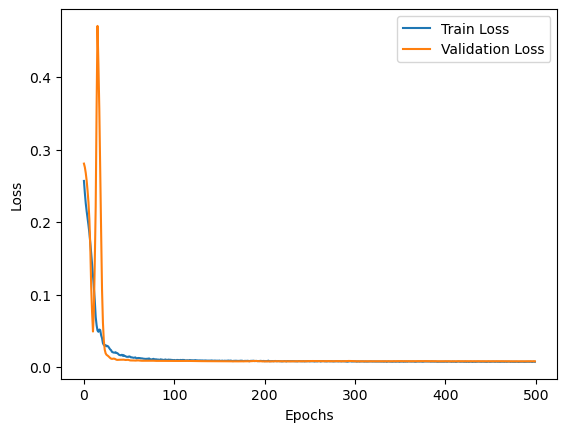

In [15]:
plot_learning_curve(num_epochs, train_losses, val_losses)